#MNIST data

Some inspiration:


*   https://github.com/safwankdb/Vanilla-GAN/blob/master/Vanilla_GAN.ipynb
*   https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
*   https://github.com/safwankdb/Vanilla-GAN/blob/master/Vanilla_GAN.ipynb


    
    

In [118]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils

We check that we have a GPU available

In [119]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU. This is important so things run faster.


In [120]:
'''
# training data normal
train_transform = transforms.Compose([ transforms.ToTensor()])


# training data augmented
train_transform_aug = transforms.Compose([transforms.RandomRotation(20), 
transforms.CenterCrop(28),
transforms.ToTensor(),])

train_transform_aug_2 = transforms.Compose([transforms.RandomApply([
                                                                    transforms.RandomRotation(20), 
                                                                    transforms.CenterCrop(28),
                                                                    transforms.ToTensor()])])


# https://pytorch.org/docs/stable/torchvision/transforms.html


# test data normal
test_transform =transforms.Compose([transforms.ToTensor()])

batch_size = 64

# combining the two training sets
trainset1 = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
trainset2 = datasets.MNIST('./data', train=True, download=True, transform=train_transform_aug)
trainset3 = datasets.MNIST('./data', train=True, download=True, transform=train_transform_aug_2)
trainset = ConcatDataset([trainset1, trainset2, trainset3])

# loading train
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

# loading test
testset = datasets.MNIST('./data', train=True, download=True, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)
'''

"\n# training data normal\ntrain_transform = transforms.Compose([ transforms.ToTensor()])\n\n\n# training data augmented\ntrain_transform_aug = transforms.Compose([transforms.RandomRotation(20), \ntransforms.CenterCrop(28),\ntransforms.ToTensor(),])\n\ntrain_transform_aug_2 = transforms.Compose([transforms.RandomApply([\n                                                                    transforms.RandomRotation(20), \n                                                                    transforms.CenterCrop(28),\n                                                                    transforms.ToTensor()])])\n\n\n# https://pytorch.org/docs/stable/torchvision/transforms.html\n\n\n# test data normal\ntest_transform =transforms.Compose([transforms.ToTensor()])\n\nbatch_size = 64\n\n# combining the two training sets\ntrainset1 = datasets.MNIST('./data', train=True, download=True, transform=train_transform)\ntrainset2 = datasets.MNIST('./data', train=True, download=True, transform=train_trans

In [121]:

transform_custom = transforms.Compose([
transforms.RandomRotation(20), 
transforms.CenterCrop(28),
transforms.ToTensor(),
])


The MNIST dataset is a built-in dataset in PyTorch (it is a very common dataset to test algorithms on). 

We import it, and set our minibatch size, by

In [122]:

batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform_custom)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)


First we plot the images to get an idea of what data we're working with. MNIST images are $28\times28$ images of handwritten digits (0-9)

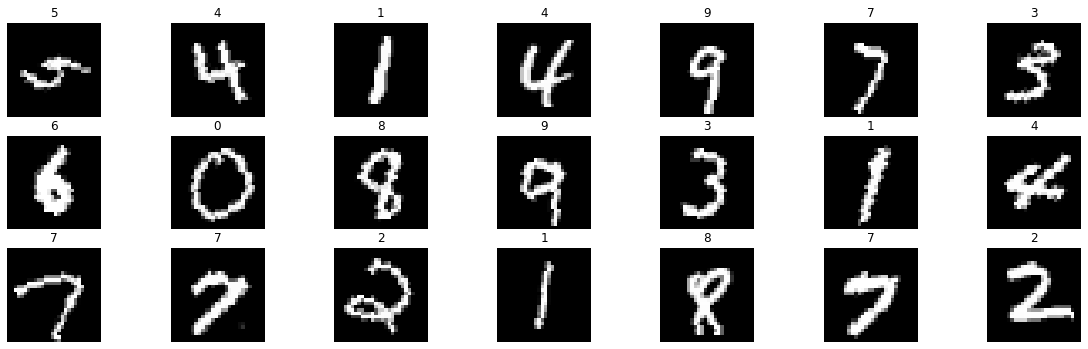

In [123]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

# Generator and discriminator

In [124]:
class Generator2(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fully_connected = nn.Sequential(
                nn.Linear(28*28, 5000), #modtager 14x14 fordi den er blevet mindre efter maxpool
                nn.ReLU(),
                #nn.Dropout(0.5),
                nn.Linear(5000, 5000),
                nn.ReLU(),
                nn.Linear(5000, 28*28),
                #nn.ReLU(),
                nn.Sigmoid()
                )
              
    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.fully_connected(x)
        return x

In [125]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=6):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  1,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 1, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

In [126]:
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fully_connected = nn.Sequential(
                nn.Linear(28*28, 5000), #modtager 14x14 fordi den er blevet mindre efter maxpool
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(5000, 5000),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(5000, 28*28),
                nn.Sigmoid()
                #nn.LeakyReLU()
                )
    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.fully_connected(x)
        return x

In [127]:
class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
      
        self.conv = nn.Sequential(
            nn.Conv2d(1,f,4,stride=2,padding=1), #1 layer
            nn.InstanceNorm2d(f),
            nn.LeakyReLU(alpha),
            nn.Conv2d(f,f*2,4,stride=2,padding=1), #2 layer 
            nn.InstanceNorm2d(f*2),
            nn.LeakyReLU(alpha),
            nn.Conv2d(f*2,f*4,4,stride=2,padding=1), #3 layer
            nn.InstanceNorm2d(f*4),
            nn.LeakyReLU(alpha),
            nn.Conv2d(f*4,f*8,4,stride=1,padding=1), #4 layer 
            nn.InstanceNorm2d(f*8),
            nn.LeakyReLU(alpha),


            nn.Conv2d(f*8,1,4,stride=1,padding=1), #5 layer
            #nn.InstanceNorm2d(1),
            #nn.Sidmoid? #Maybe this should be erased   #Because we use .Logsigmoid
        )
        
    def forward(self, x):
        return self.conv(x)

# Hyperparameters

In [128]:
alpha=0.2 #LeakyReLU slope
beta=0.5 #Beta1 in Adam
lrD=0.0004 #learningrate in Adam 0.0002, 
lrG=0.0001 #learningrate in Adam 0.0001
lambda_cycle=10
lambda_identity=5

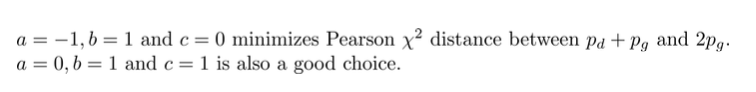

In [129]:
#LSGAN LOSS
a=-1
b=1
c=0

#a=0
#b=1
#c=1

In [130]:
def LSGAN_loss_D_true(input_1):
  return 0.5*torch.mean((input_1 - b)**2) 

In [131]:
def LSGAN_loss_D_false(input_2):
  return 0.5* torch.mean((input_2-a)**2)

In [132]:
def LSGAN_loss_G(input_1):
 return 0.5 * torch.mean((input_1 - c)**2)

# Initialize model

In [133]:
net_G = Generator().to(device)
net_D = Discriminator().to(device)

# Initialize optimizer

In [134]:
optimizer_G = torch.optim.Adam(net_G.parameters(), lr=lrG) # if sucks try ADAM
optimizer_D=torch.optim.Adam(net_D.parameters(), lr=lrD)


In [135]:
optimizer_G.param_groups[0]['betas']=(0.5,0.99)
optimizer_D.param_groups[0]['betas']=(0.5,0.99)


# Initialize loss

In [136]:
#criterion = nn.BCELoss()
criterion = nn.L1Loss()

# Train

In [137]:
real_label = 1
fake_label = 0

In [138]:
for i, (data, target) in enumerate(train_loader):
  data1=data.to(device)
  break

In [139]:
fixed_noise = torch.randn_like(data1, device=device)

We train the network for five epochs

In [140]:
from torch.autograd import Variable

In [141]:
# Training Loop
num_epochs=15

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    #for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
    for i, (data, target) in enumerate(train_loader):
    
        data=data.to(device)
           
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        # Set gradients to zero
        net_D.zero_grad()
        # Let discriminator evaluate true data
        Dxtrue = net_D(data)
        # Calulate loss on this evaluation
        errD_real = LSGAN_loss_D_true(Dxtrue)
        # this is for plotting
        D_x = errD_real.mean().item()
        
        # Generate random noise
        noise = torch.randn_like(data)
        # Let the generator create a digit from the random noise
        fake = net_G(noise)  
        # Let the discriminator evaluate the image (.detach() stops backprop, so it doesn't influence the generator)
        DGz = net_D(fake.detach())
        # Calculate loss
        errD_fake = LSGAN_loss_D_false(DGz)  
        # this is for plotting
        D_G_z1 = errD_fake.mean().item()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Backprop
        errD.backward()
        # Update D
        optimizer_D.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        # Set the gradients to zero
        net_G.zero_grad()
        # Let the updated discriminator evaluate the fake image from before
        output = net_D(fake)
        # Calculate the loss
        errG = LSGAN_loss_G(output)
        # This is for plotting
        D_G_z2 = errG.mean().item()
        # Backpropagate
        errG.backward()
        # Update G
        optimizer_G.step()


        # Output training stats
        if i % 300 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake_pic = net_G(fixed_noise).detach().cpu()
                #print('fake shape 2{}'.format(fake.shape))
              
                #fake=fake.view(-1,64,1,28,28)
            #img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            img_list.append(fake_pic)
        iters += 1

Starting Training Loop...
[0/15][0/938]	Loss_D: 0.9826	Loss_G: 1.7625	D(x): 0.3521	D(G(z)): 0.6305 / 1.7625
[0/15][300/938]	Loss_D: 0.1119	Loss_G: 0.3985	D(x): 0.0883	D(G(z)): 0.0236 / 0.3985
[0/15][600/938]	Loss_D: 0.0941	Loss_G: 0.4093	D(x): 0.0470	D(G(z)): 0.0471 / 0.4093
[0/15][900/938]	Loss_D: 0.2179	Loss_G: 0.7609	D(x): 0.1027	D(G(z)): 0.1152 / 0.7609
[1/15][0/938]	Loss_D: 0.0653	Loss_G: 0.5948	D(x): 0.0539	D(G(z)): 0.0115 / 0.5948
[1/15][300/938]	Loss_D: 0.7589	Loss_G: 1.0953	D(x): 0.0347	D(G(z)): 0.7243 / 1.0953
[1/15][600/938]	Loss_D: 0.2765	Loss_G: 0.5795	D(x): 0.0493	D(G(z)): 0.2273 / 0.5795
[1/15][900/938]	Loss_D: 0.3019	Loss_G: 0.2491	D(x): 0.1779	D(G(z)): 0.1240 / 0.2491
[2/15][0/938]	Loss_D: 0.3467	Loss_G: 0.1221	D(x): 0.2593	D(G(z)): 0.0874 / 0.1221
[2/15][300/938]	Loss_D: 0.3083	Loss_G: 0.3054	D(x): 0.1578	D(G(z)): 0.1504 / 0.3054
[2/15][600/938]	Loss_D: 0.4496	Loss_G: 0.4141	D(x): 0.1386	D(G(z)): 0.3110 / 0.4141
[2/15][900/938]	Loss_D: 0.5658	Loss_G: 0.1572	D(x): 0.52

Loss_D kommer ned på 0.5, hvilket vel betyder at den gætter rigtigt 50 pct af gangene? Ikke så godt <br>
Loss_G kommer nærmest helt ned på 0, hvilket heller ikke er så godt, da det betyder at den er for god til discriminatoren?


#Plotting fake numbers:

In [155]:
len(img_list)

30

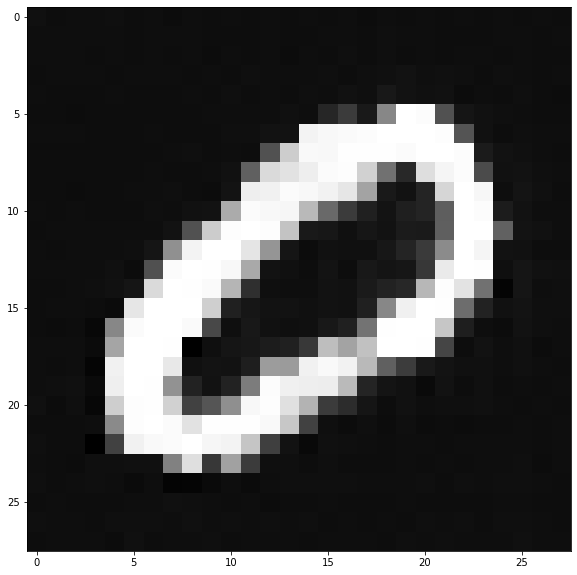

In [147]:
#for i, (data, target) in enumerate(train_loader):
#noise = torch.randn_like(data)
        #print(noise.shape)

        # Generate fake image batch with G
fixed_noise2 = torch.randn_like(data1, device=device)
fake2 = net_G(fixed_noise2).detach().cpu()
#fake[0][0].shape
#plt.imshow(fixed_noise2[0][0].detach().cpu(),cmap='gray')
plt.imshow(fake2[0][0].numpy(),cmap='gray')
#plt.imshow(np.transpose(vutils.make_grid(fake2[0][0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

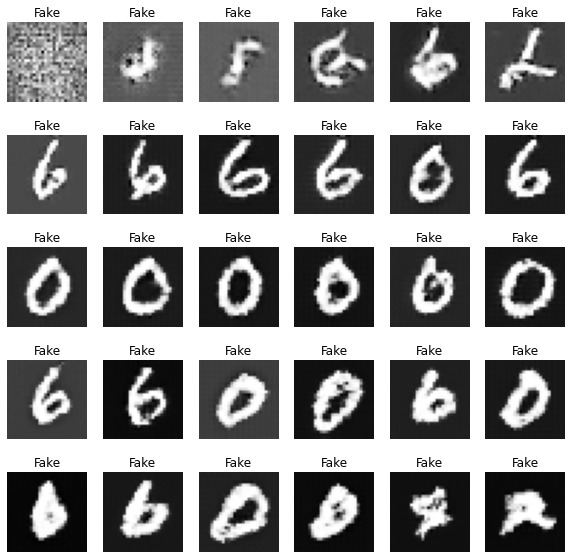

In [173]:
plt.rcParams['figure.figsize'] = [10, 10]
#plt.figure(1)
for k in range(30):
    
    plt.subplot(5, 6, k+1)
    plt.imshow(img_list[k][0][0].numpy(),cmap='gray') #-1 for the last in img_list
    plt.title('Fake')
    plt.axis('off')

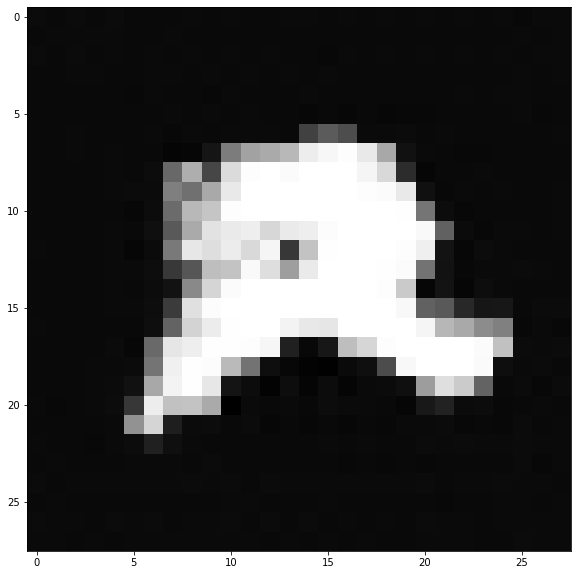

In [167]:
plt.imshow(img_list[29][0][0].numpy(),cmap='gray') #-1 for the last in img_list

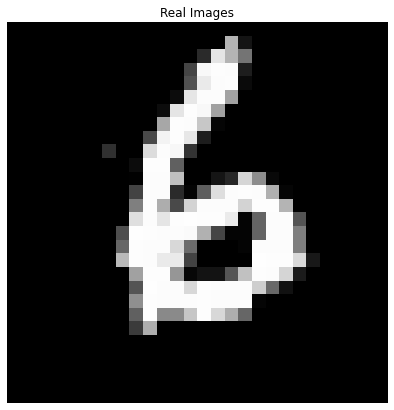

In [144]:
# Grab a batch of real images from the dataloader
real_batch,_ = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

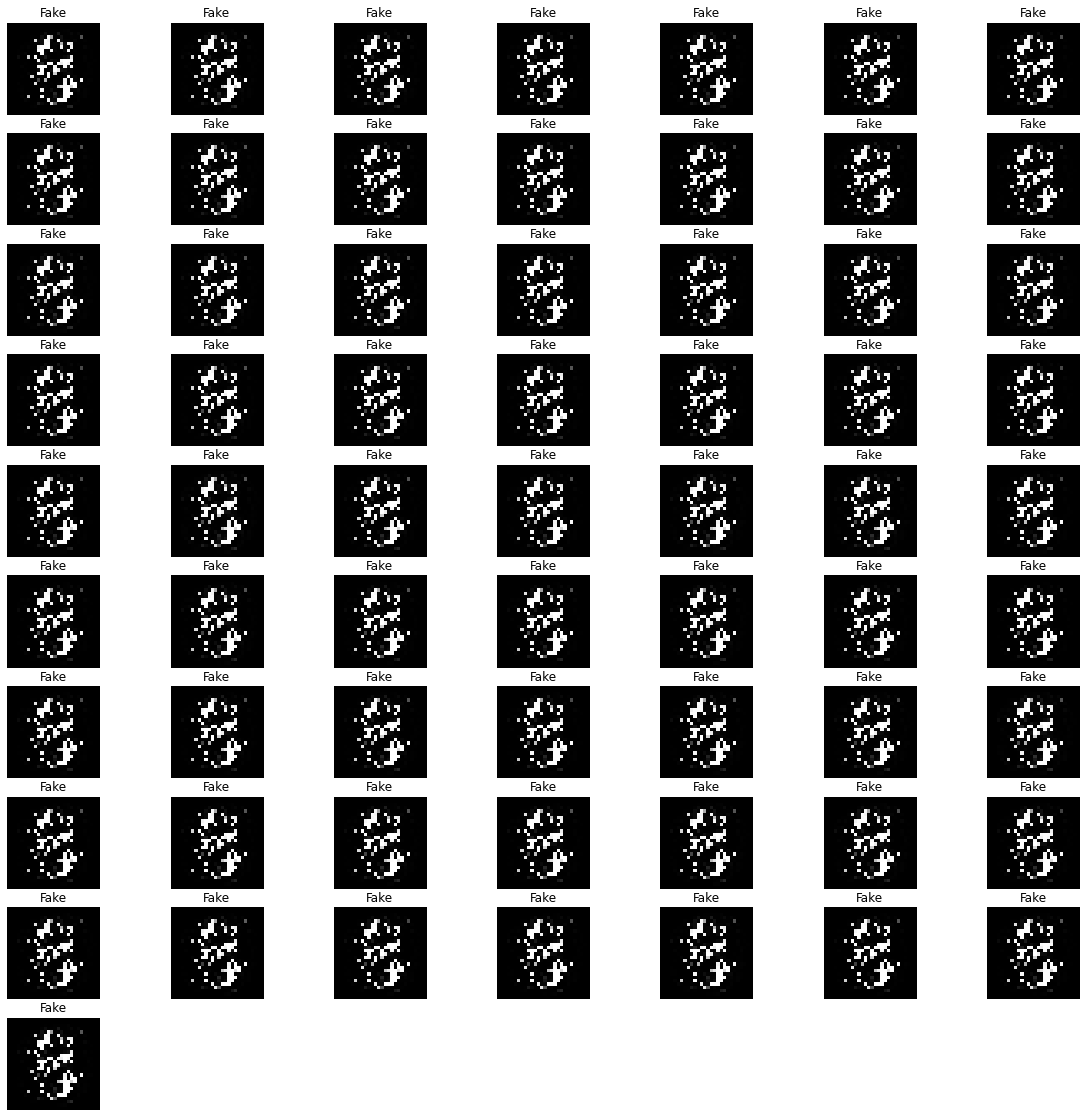

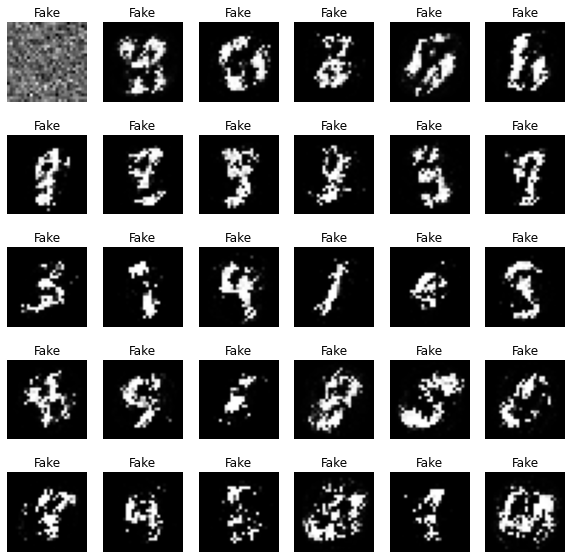

# Interpolation

https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/gan.ipynb#scrollTo=9WHvOQs87C00

In [145]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

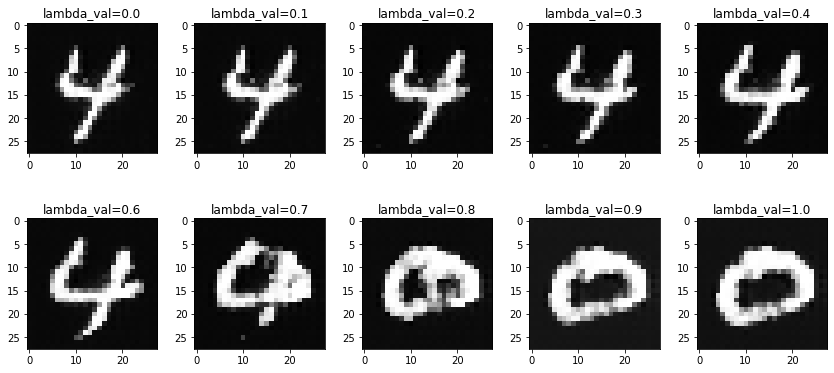

In [146]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

net_G.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()
        return inter_image.view(-1,64,1,28,28).squeeze(0)
    


latent_1 = torch.randn_like(real_batch, device=device)
latent_2 = torch.randn_like(real_batch, device=device)


# interpolation lambdas
#lambda_range=np.linspace(0,10,100)
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):

    inter_image=interpolation(float(l), net_G, latent_1, latent_2)
   
    #inter_image = to_img(inter_image)
    
    #image = inter_image[0,0,:,:].numpy()

    #axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].imshow(inter_image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Saving the model states

In [175]:
#torch.save(net_D.state_dict(), 'drive/My Drive/DLiCV/Project 3/net_D_23june')
#torch.save(net_G.state_dict(), 'drive/My Drive/DLiCV/Project 3/net_G_23june')

In [174]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
